# Modeling Stock Market Sentiment with CNNs and Keras

In this tutorial, we will build a CNN Network to predict the stock market sentiment based on a comment about the market.

## Setup

We will use the following libraries for our analysis:

* numpy - numerical computing library used to work with our data
* pandas - data analysis library used to read in our data from csv
* tensorflow - a lower level deep learning framework used for modeling
* keras - a higher level deep learning library that absracts away a lot of DL details. Keras will use Tensforflow in the background

We will also be using the python Counter object for counting our vocabulary items and we have a util module that extracts away a lot of the details of our data processing. Please read through the util.py to get a better understanding of how to preprocess the data for analysis.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

import utils as utl
from collections import Counter

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from keras.layers import Dense, Input, Flatten, Dropout#, Merge
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model

## Processing Data

We will train the model using messages tagged with SPY, the S&P 500 index fund, from [StockTwits.com](https://www.stocktwits.com). StockTwits is a social media network for traders and investors to share their views about the stock market. When a user posts a message, they tag the relevant stock ticker ($SPY in our case) and have the option to tag the messages with their sentiment – “bullish” if they believe the stock will go up and “bearish” if they believe the stock will go down.

Our dataset consists of approximately 100,000 messages posted in 2017 that are tagged with $SPY where the user indicated their sentiment. Before we get to our CNN Network we have to perform some processing on our data to get it ready for modeling.

#### Read and View Data

First we simply read in our data using pandas, pull out our message and sentiment data into numpy arrays. Let's also take a look at a few samples to get familiar with the data set.

In [2]:
# read data from csv file
data = pd.read_csv("data/StockTwits_SPY_Sentiment_2017.gz",
                   encoding="utf-8",
                   compression="gzip",
                   index_col=0)

# get messages and sentiment labels
messages = data.message.values
labels = data.sentiment.values

# View sample of messages with sentiment

for i in range(10):
    print("Messages: {}...".format(messages[i]),
          "Sentiment: {}".format(labels[i]))

Messages: $SPY crazy day so far!... Sentiment: bearish
Messages: $SPY Will make a new ATH this week. Watch it!... Sentiment: bullish
Messages: $SPY $DJIA white elephant in room is $AAPL. Up 14% since election. Strong headwinds w/Trump trade & Strong dollar. How many 7's do you see?... Sentiment: bearish
Messages: $SPY blocks above. We break above them We should push to double top... Sentiment: bullish
Messages: $SPY Nothing happening in the market today, guess I'll go to the store and spend some $.... Sentiment: bearish
Messages: $SPY What an easy call. Good jobs report: good economy, markets go up.  Bad jobs report: no more rate hikes, markets go up.  Win-win.... Sentiment: bullish
Messages: $SPY BS market.... Sentiment: bullish
Messages: $SPY this rally all the cheerleaders were screaming about this morning is pretty weak. I keep adding 2 my short at all spikes... Sentiment: bearish
Messages: $SPY Dollar ripping higher!... Sentiment: bearish
Messages: $SPY no reason to go down !... S

#### Check Message Lengths

We will also want to get a sense of the distribution of the length of our inputs. We check for the longest and average messages. We will need to make our input length uniform to feed the data into our model so later we will have some decisions to make about possibly truncating some of the longer messages if they are too long. We also notice that one message has no content remaining after we preprocessed the data, so we will remove this message from our data set.

In [3]:
messages_lens = Counter([len(x) for x in messages])
print("Zero-length messages: {}".format(messages_lens[0]))
print("Maximum message length: {}".format(max(messages_lens)))
print("Average message length: {}".format(np.mean([len(x) for x in messages])))

Zero-length messages: 0
Maximum message length: 635
Average message length: 75.64462136603174


In [4]:
messages, labels = utl.drop_empty_messages(messages, labels)

#### Preprocess Messages

Working with raw text data often requires preprocessing the text in some fashion to normalize for context. In our case we want to normalize for known unique "entities" that appear within messages that carry a similar contextual meaning when analyzing sentiment. This means we want to replace references to specific stock tickers, user names, url links or numbers with a special token identifying the "entity". Here we will also make everything lower case and remove punctuation.

In [5]:
messages = np.array([utl.preprocess_ST_message(message) for message in messages])

#### Generate Vocab to Index Mapping

We will use a Keras `Tokenizer` in order to generate our word index. The tockenizer takes our vocabulary and assigns each word a unique index from 1 to *VOCAB_SIZE*. Zero is reserved for padding which we will get to in a bit

In [6]:
VOCAB = sorted(list(set(messages)))
VOCAB_SIZE = len(VOCAB)

In [7]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(messages)

In [8]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 31975 unique tokens.


In [9]:
for word, i in word_index.items():
    if i > 10:
        break
    print(str(i) + ' - ' + word)
    

1 - ticker
2 - number
3 - the
4 - to
5 - user
6 - a
7 - is
8 - and
9 - this
10 - in


#### Encode Messages and Labels

We need to "translate" our text to number for our algorithm to take in as inputs. We call this translation an encoding. We encode our messages to sequences of numbers where each nummber is the word index from the mapping we made earlier. The phrase "I am bullish" would now look something like [1, 234, 5345] where each number is the index for the respective word in the message. We can do this very easily with our tokenizer by calling the `text_to_sequences` method. For our sentiment labels we will simply encode "bearish" as 0 and "bullish" as 1.

In [10]:
sequences = tokenizer.texts_to_sequences(messages)

In [11]:
labels = to_categorical(utl.encode_ST_labels(labels))

#### Pad Messages

Next need to do is make our message inputs the same length. In our case, the average message length is 78 words so we will use a max length of around this amount. We need to Zero Pad the rest of the messages that are shorter. We will use a left padding that will pad all of the messages that are shorter than 244 words with 0s at the beginning. So our encoded "I am bullish" messages goes from [1, 234, 5345] (length 3) to [0, 0, 0, 0, 0, 0, ... , 0, 0, 1, 234, 5345] (length 80). Keras has a build in processing function called `pad_sequences` to do this for us.

In [12]:
MAX_SEQUENCE_LENGTH = 80
cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [13]:
cnn_data

array([[    0,     0,     0, ...,    38,    50,   381],
       [    0,     0,     0, ...,    61,   198,    15],
       [    0,     0,     0, ...,   110,    20,    59],
       ...,
       [    0,     0,     0, ...,    39,    47,  1584],
       [    0,     0,     0, ...,    57, 10003,  8709],
       [    0,     0,     0, ...,     1,     1,     1]], dtype=int32)

#### Train and Validation Split

The last thing we do is split our data into tranining and validation sets. Typically we will want a test set as well but we will skip this for demonstration purposes.

In [14]:
VALIDATION_SPLIT = .2
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

In [15]:
indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]

In [16]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

## Building and Training our CNN Network

In this section we will load our pretrained word embeddings and build out CNN Model.

#### Glove Embeddings

For this example we will use the Twitter GloVe embeddings that can be found here https://nlp.stanford.edu/projects/glove/. We have our embeddings saved in a text file in our data directory so first we load parse these and load them in to a dictionary.

Next we get the mean and standard devation of all embedding values. The pretrained GloVe embeddings won't contain all of the words in our vocabularly so we will seed our embedding matrix for our vocabularly with random draws from a normal distribution with mean *emb_mean* and standard deviation *emb_std*. Next we iterate through all of the words in our vocabulary and set our word embeddings to the GloVe vectors where they are available.

In [17]:
EMBEDDING_DIM = 50
EMBEDDING_FILE = 'data/glove.twitter.27B.50d.txt'

def get_embed_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

In [18]:
embeddings_index = dict(get_embed_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE,  encoding="utf8"))

In [19]:
embeddings_values=list(embeddings_index.values())

def equal_shape(input_list):
    padded_list = []
    for arr in input_list:
        if len(arr) < 50:
            padded_arrays = [np.pad(arr, (0, 50 - len(arr)), 'constant', constant_values=np.mean(arr))]
            arr = padded_arrays[0]  # Assign the first element of padded_arrays to arr
        padded_list.append(arr)
    return padded_list
embeddings_values = equal_shape(embeddings_values)

all_embs = np.stack(embeddings_values)
all_embs
emb_mean,emb_std = all_embs.mean(), all_embs.std()

In [20]:
embedding_matrix = np.random.normal(emb_mean, emb_std, (len(word_index) + 1, EMBEDDING_DIM))

In [21]:
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i] = embedding_vector
    if i < 10:
        print(word + ' - ' + str(len(embedding_vector)) + ' - ' + str(embedding_vector))

ticker - 50 - [ 6.9041e-01 -2.0992e-01 -7.2670e-01 -3.1076e-01  1.1150e+00 -7.6897e-02
 -2.2403e-01 -2.5761e-01  7.8245e-01 -9.6844e-01  1.2229e-01 -7.4801e-01
 -8.8053e-01 -4.1908e-01 -7.5446e-01 -1.2846e+00  8.3615e-01  6.5154e-01
  1.2732e+00 -4.8352e-01 -7.0690e-01 -6.4756e-01  6.0602e-01 -5.7739e-01
 -6.4232e-01  8.8620e-01  1.5056e-01 -7.0960e-02 -1.4028e+00 -4.9453e-02
  4.0681e-02  1.1366e-01 -1.4865e-01 -1.3882e-01  6.2105e-02 -3.7170e-01
  4.5915e-01 -1.1758e-01  8.1187e-01 -7.2503e-01  1.5220e-01 -2.6939e-01
  3.1259e-01  4.5602e-01  4.4240e-01  1.3903e-01 -2.4801e-02 -7.4742e-01
 -8.6883e-04  6.2808e-01]
number - 50 - [ 0.48737   0.16796  -0.41658  -0.029931  0.25068  -0.58508   1.399
  0.43136   0.18158   0.40476  -0.38604  -0.55495  -3.7413   -0.29016
 -0.1765    0.32337   0.24366  -0.49777  -0.094325 -0.25783  -0.21521
  0.2009    0.73693  -0.063841 -0.81366   0.041353  0.10923  -1.491
  0.40854   0.25073  -0.36234  -0.16865  -0.12642  -0.2194    0.95608
  0.21596   0.07

In [22]:
embedding_matrix.shape

(31976, 50)

In [23]:
from keras.layers import Concatenate, Average   

#### Model and Training

Here we build our Convoluational Neural Network using Keras. We will use the architecture from the Yoon Kim model (https://arxiv.org/abs/1408.5882) with some adjustments. We first start with our embeddings layer and then have 3 parallel 1D convulational layers with 128 filters and sizes [3, 4, 5] respectively. We concatenate these results, pass to a dropout layer for regularization, and then to a fully connected layer with relu activation and finally a softmax layer to make out predictions.

Here we also define that we will use a categorical crossentropy loss funcation and an Adam optimizer.

In [24]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs) # Concatenate()(mode='concat', concat_axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

In [25]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [26]:
model = ConvNet(embedding_matrix, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                len(labels[0]), False)

and now we train!

In [27]:
train = model.fit(x_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(x_val, y_val),
                    batch_size=10)
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.8517
Testing Accuracy:  0.7154


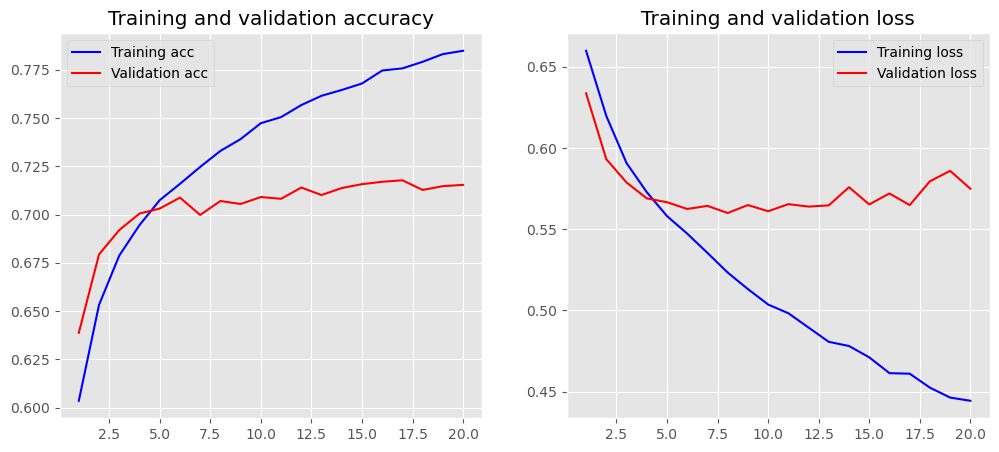

In [28]:
plot_history(train)

In [29]:
newMessage = [ "$SPY $BTC will bring markets down"]

In [30]:
newMessage = np.array([utl.preprocess_ST_message(message) for message in newMessage])
sequences = tokenizer.texts_to_sequences(newMessage)
cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
yNew = model.predict(cnn_data)
preds_classes = np.argmax(yNew, axis=-1)
preds_classes[0]

1/1 [==============================] - 0s 82ms/step


0

In [31]:
newMessage =['$SPY $DJIA What if it is just a huge bull flag in the making']

In [32]:
newMessage = np.array([utl.preprocess_ST_message(message) for message in newMessage])
sequences = tokenizer.texts_to_sequences(newMessage)
cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
yNew = model.predict(cnn_data)
preds_classes = np.argmax(yNew, axis=-1)
preds_classes[0]

1/1 [==============================] - 0s 11ms/step


1

In [33]:
#ToDo: Retrain the Model by increase the number of epochs 
# train = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                  # epochs=50, batch_size=128)

In [34]:
#ToDo:
#does increasig epoch always improve accuracy to help classify sentiments better?

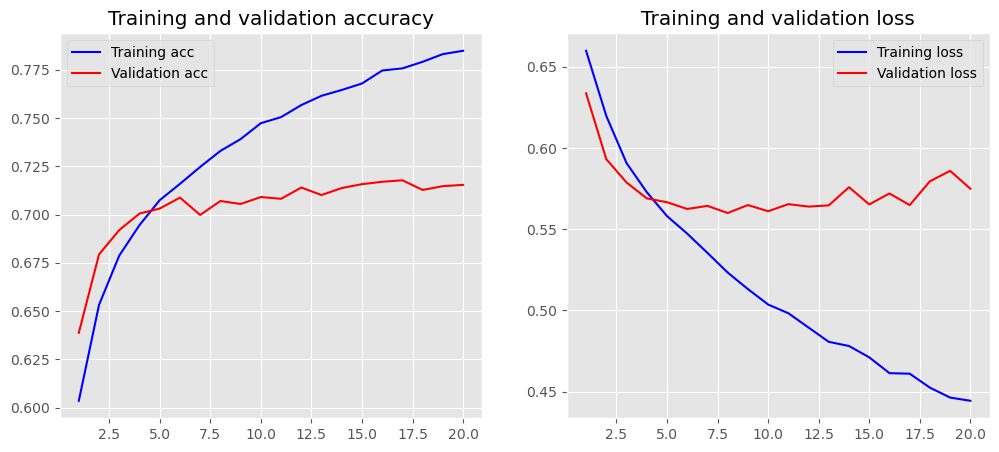

In [35]:
plot_history(train)

In [36]:
model.save_weights('model_trained.txt') # Saving the model

In [37]:
loss, accuracy = model.evaluate(x_val, y_val, verbose=True)
print(loss)
print(accuracy)

607/607 [==============================] - 2s 4ms/step - loss: 0.5749 - acc: 0.7154
0.5748996734619141
0.7153612375259399


In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 80, 50)               1598800   ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 78, 128)              19328     ['embedding[0][0]']           
                                                                                                  
 conv1d_1 (Conv1D)           (None, 77, 128)              25728     ['embedding[0][0]']           
                                                                                              

In [39]:
#ToDo:
# Predict a new sentence using the Trained Model